# Assignment 2 DA3 Assignment 2: Finding fast growing firms 2025

Petra Ilic

Elsa Andera Rodriguez


In [41]:
import os
import sys
import warnings
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

import py_helper_functions as da


## Import data: Output from "ch17-firm-exit-data-prep", modifying the panel for 2010-2015.

In [2]:
data = pd.read_csv("bisnode_firms_clean.csv")

## Define and create the binary variable.

In [3]:
# Calculate the 20th percentile
percentile_20 = data["sales_mil_log"].quantile(0.20)

# Create binary column: 0 if below 20th percentile, 1 if above
data["growth_binary"] = np.where(data["sales_mil_log"] <= percentile_20, 0, 1)

# Check the distribution
print(f"\nDistribution of binary column:")
print(data["growth_binary"].value_counts())


Distribution of binary column:
growth_binary
1    15228
0     3808
Name: count, dtype: int64


## Define helper functions

In [4]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

## Define variables

In [5]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "share_eq",
    "subscribed_cap",
]

In [6]:
#financial variables
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

In [7]:
#flag variables
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

In [8]:
#human capital related variables
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [9]:
#firms history related variables
firm = ["age", "age2", "new", "ind2_cat", "C(m_region_loc)", "C(urban_m)"]

In [10]:
#interactons for logit and lasso
interactions1 = [
    "ind2_cat*age",
    "ind2_cat*age2",
    "ind2_cat*ceo_age",
    "ind2_cat*foreign_management",
    "ind2_cat*female",
    "ind2_cat*C(urban_m)",
    "ind2_cat*labor_avg_mod",
]

In [11]:
#model setup: simple logit
M1 = ["profit_loss_year_pl",
    "ind2_cat",
]
M2 = ["profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs",
    "curr_liab_bs_flag_high",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "ind2_cat",
]
M3 = firm + engvar 
M4 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)
M5 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + interactions1
)

In [12]:
#logit+ lasso
logit_lasso_vars = (engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + interactions1
)

In [13]:
# CART and RF (no interactions, no modified features)
rfvars = rawvars + hr + firm + qualityvars

## Modelling

### 1. Linear Probability Model

In [14]:
ols_modelx2 = smf.ols("growth_binary~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          growth_binary   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     141.1
Date:                Tue, 10 Feb 2026   Prob (F-statistic):          5.39e-259
Time:                        17:03:07   Log-Likelihood:                -8651.2
No. Observations:               19036   AIC:                         1.732e+04
Df Residuals:                   19026   BIC:                         1.740e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8276      0.016     53.108      0.000       0.797       0.858
profit_loss_year_pl         0.3089      0.013     24.475      0.000       0.284       0.334
fixed_assets_bs             0.0794      0.010      8.161      0.000       0.060       0.099
share_eq_bs                -0.0423      0.008     -5.442      0.000      -0.058      -0.027
curr_liab_bs                0.1740      0.013     13.478      0.000       0.149       0.199
curr_liab_bs_flag_high     -0.1313      0.011    -11.998      0.000      -0.153      -0.110
curr_liab_bs_flag_error    -0.0576      0.148     -0.389      0.698      -0.348       0.233
age                         0.0020      0.000      4.432      0.000       0.001       0.003
foreign_management          0.0093      0.009      1.049      0.294      -0.008       0.027
ind2_cat                   -0.0019      0.000     -7.461      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     3963.346   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6925.546
Skew:                          -1.438   Prob(JB):                         0.00
Kurtosis:                       3.678   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2. Logit

In [16]:
logit_modelx2 = smf.logit("growth_binary~" + "+".join(M2), data).fit()
logit_modelx2.summary()

Optimization terminated successfully.
         Current function value: 0.455885
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          growth_binary   No. Observations:                19036
Model:                          Logit   Df Residuals:                    19026
Method:                           MLE   Df Model:                            9
Date:                Tue, 10 Feb 2026   Pseudo R-squ.:                 0.08907
Time:                        17:03:08   Log-Likelihood:                -8678.2
converged:                       True   LL-Null:                       -9526.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.7219      0.113     15.191      0.000       1.500       1.944
profit_loss_year_pl         1.8123      0.057     31.650      0.000       1.700       1.925
fixed_assets_bs             0.5434      0.061      8.953      0.000       0.424       0.662
share_eq_bs                -0.2977      0.046     -6.415      0.000      -0.389      -0.207
curr_liab_bs                1.2730      0.093     13.623      0.000       1.090       1.456
curr_liab_bs_flag_high     -0.9804      0.080    -12.210      0.000      -1.138      -0.823
curr_liab_bs_flag_error    -0.2490      0.738     -0.337      0.736      -1.696       1.198
age                         0.0126      0.003      4.034      0.000       0.006       0.019
foreign_management          0.0873      0.064      1.361      0.174      -0.038       0.213
ind2_cat                   -0.0138      0.002     -7.246      0.000      -0.017      -0.010
===========================================================================================
"""

In [17]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:          growth_binary
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
profit_loss_year_pl         0.2617      0.008     34.415      0.000       0.247       0.277
fixed_assets_bs             0.0785      0.009      8.999      0.000       0.061       0.096
share_eq_bs                -0.0430      0.007     -6.432      0.000      -0.056      -0.030
curr_liab_bs                0.1838      0.013     13.747      0.000       0.158       0.210
curr_liab_bs_flag_high     -0.1416      0.012    -12.294      0.000      -0.164      -0.119
curr_liab_bs_flag_error    -0.0359      0.107     -0.337      0.736      -0.245       0.173
age                         0.0018      0.000      4.038      0.000       0.001       0.003
foreign_management          0.0126      0.009      1.361      0.173      -0.006       0.031
ind2_cat                   -0.0020      0.000     -7.264      0.000      -0.003      -0.001
===========================================================================================
"""

## Train / Test

In [18]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [51]:
print("Total")
print(data["growth_binary"].value_counts(normalize=True))
print("Train")
print(data_train["growth_binary"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["growth_binary"].value_counts(normalize=True))


Total
growth_binary
1    0.799958
0    0.200042
Name: proportion, dtype: float64
Train
growth_binary
1    0.803257
0    0.196743
Name: proportion, dtype: float64
Holdout
growth_binary
1    0.786765
0    0.213235
Name: proportion, dtype: float64


In [52]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
logit_model_vars = [M1, M2, M3, M4, M5]

In [53]:
C_value_logit = [1e20]

In [54]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "growth_binary~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [55]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.377348,0.372059,0.341916,0.291911,0.299949
1,0.370293,0.365542,0.341312,0.298524,0.301260
2,0.375649,0.370990,0.340918,0.292352,0.294196
3,0.375460,0.371647,0.340530,0.293600,0.301926
4,0.384370,0.379524,0.353860,0.300602,0.305946


### b) Logit + LASSO


In [56]:
model_equation = "growth_binary~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [57]:
#normalize X
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [58]:
#Set parameters
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

In [59]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [60]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.380480
1,0.046416,0.001768,0.341888
2,0.021544,0.003810,0.327054
3,0.010000,0.008209,0.316744
4,0.004642,0.017685,0.307849
5,0.002154,0.038101,0.302108
6,0.001000,0.082086,0.297743
7,0.000464,0.176848,0.295634
8,0.000215,0.381008,0.294771
9,0.000100,0.820856,0.294432


In [61]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [62]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC


In [63]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "growth_binary~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

In [64]:
#for lasso
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

In [66]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [67]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary.round(3)

,Number of Coefficients,CV RMSE,CV AUC
M1,3,0.377,0.633
M2,10,0.372,0.681
M3,24,0.344,0.814
M4,68,0.295,0.917
M5,76,0.301,0.911
LASSO,68,0.294,0.918


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [68]:
best_logit = logit_models["M4"]
model_equation = "growth_binary~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

In [69]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["growth_binary"]), 3)

np.float64(0.298)

### calibration curve

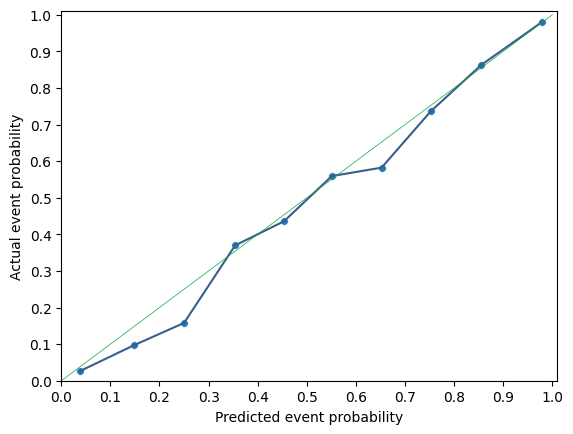

In [70]:
da.create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="growth_binary",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

In [71]:
#confusion table
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (growth_binary less than 20%): ", counts[0])
print(values[1], " (growth_binary above 20%): ", counts[1])

0.0  (growth_binary less than 20%):  577
1.0  (growth_binary above 20%):  3231


In [72]:
cm_object1 = confusion_matrix(
    data_holdout["growth_binary"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,454,358
Actual growth_binary,123,2873


In [73]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1b

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,454,358
Actual growth_binary,123,2873


In [74]:
mean_predicted_growth_binary_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_binary_prob, 3)

np.float64(0.794)

In [75]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_binary_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm2

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,695,117
Actual growth_binary,554,2442


### visualize roc

In [76]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["growth_binary"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [77]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

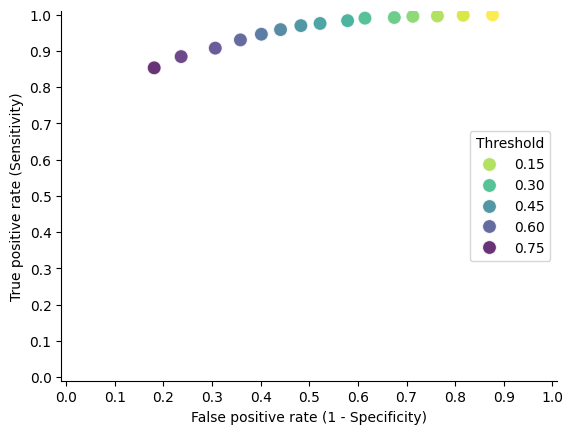

In [78]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

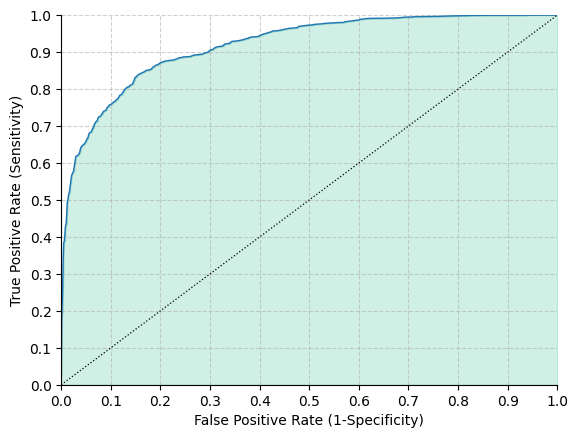

In [79]:
create_roc_plot(data_holdout["growth_binary"], data_holdout["best_logit_pred_proba"])

## we have loss function

In [80]:
FP = 1
FN = 10
cost = FN / FP

In [81]:
prevelance = y_train.sum() / len(y_train)

In [83]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("growth_binary ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["growth_binary"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [84]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [85]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.506759,0.510753,0.196743,0.208210
1,M2,0.306625,0.286074,0.195693,0.207882
2,M3,0.088741,0.012816,0.193723,0.208210
3,M4,0.072792,0.085104,0.172380,0.181938
4,M5,0.107048,0.167942,0.172906,0.176355
5,LASSO,0.065041,0.068761,0.173497,0.183580


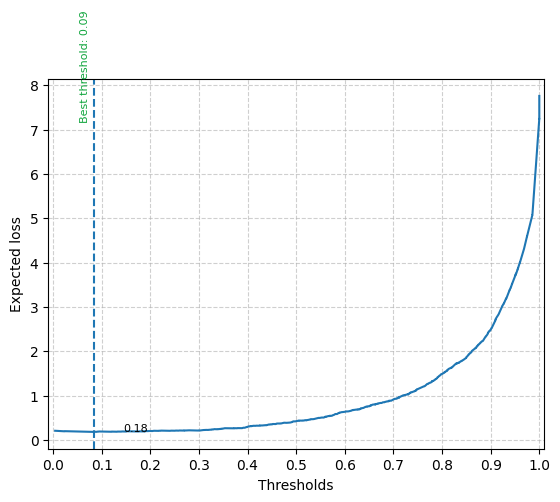

In [86]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

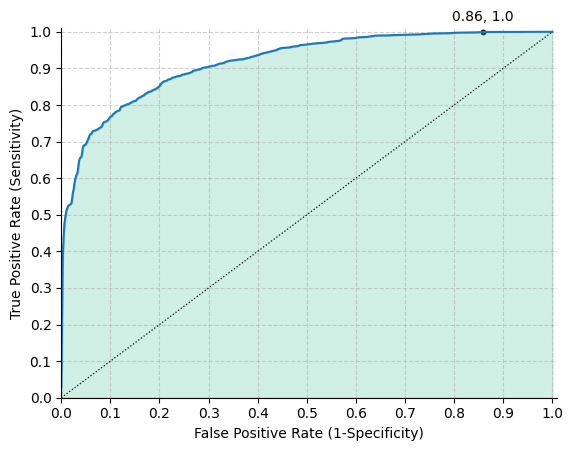

In [87]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)